In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [5]:
train = pd.read_csv("data/train.csv", parse_dates=["datetime"])
train.shape

(10886, 12)

In [4]:
test = pd.read_csv("data/test.csv", parse_dates=["datetime"])
test.shape

(6493, 9)

In [6]:
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["hour"] = train["datetime"].dt.hour
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 16)

In [7]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["hour"] = test["datetime"].dt.hour
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 13)

In [8]:
# 연속형 feature와 범주형 feature
# 범주형 feature의 type을 category로 변경 해 준다.
categorical_feature_names = ["season","holiday","workingday","weather",
                             "dayofweek","month","year","hour"]

In [9]:
for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [10]:
feature_names = ["season", "weather", "temp", "atemp", "humidity",
                 "year", "hour", "dayofweek", "holiday", "workingday"
                ]

feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [11]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 10)


,season,weather,temp,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,1,1,9.84,14.395,81,2011,0,5,0,0
1,1,1,9.02,13.635,80,2011,1,5,0,0
2,1,1,9.02,13.635,80,2011,2,5,0,0
3,1,1,9.84,14.395,75,2011,3,5,0,0
4,1,1,9.84,14.395,75,2011,4,5,0,0


In [12]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 10)


,season,weather,temp,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,2011,0,3,0,1
1,1,1,10.66,13.635,56,2011,1,3,0,1
2,1,1,10.66,13.635,56,2011,2,3,0,1
3,1,1,10.66,12.880,56,2011,3,3,0,1
4,1,1,10.66,12.880,56,2011,4,3,0,1


In [13]:
label_name = "count"

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

In [15]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values, convertExp=True):

    if convertExp:
        predicted_values = np.exp(predicted_values),
        actual_values = np.exp(actual_values)
        
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    # 값이 0일 수도 있어서 로그를 취했을 때 마이너스 무한대가 될 수도 있기 때문에 1을 더해 줌
    # 로그를 씌워주는 것은 정규분포로 만들어주기 위해
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    # 평균을 낸다.
    mean_difference = difference.mean()
    
    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    
    return score

# 선형회귀 모델 Linear Regression Model

- 선형회귀 또는 최소제곱법은 가장 간단하고 오래된 회귀용 선형 알고리즘
- 선형회귀는 예측과 훈련 세트에 있는 타깃 y사이의 평균제곱오차(MSE)를 최소화하는 파라미터 w와 b를 찾는다.
- 매개변수가 없는 것이 장점이지만, 모델의 복잡도를 제어할 수 없다는 단점이 있다.
- 아래 위키피디아에서 가져 온 그래프에서 파란선이 선형회귀 모델을 나타내고 빨간점들이 훈련데이터를 나타낸다.
![liner](./img/liner-regression.png)

## Linear Regression Model 실험

- 선형 회귀 모델을 적용하여 실험을 해보자
- RMSLE 값이 0에 가까울수록 성능이 우수하다.
- 선형 회귀 모델의 경우 1에 가까운 숫자가 나왔기 때문에 성능이 우수하지 못함을 할 수 있다.

In [16]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 선형회귀 모델을 초기화
lModel = LinearRegression()

# 모델을 학습시킨다.
y_train_log = np.log1p(y_train)
lModel.fit(X_train, y_train_log)

# 예측하고 정확도를 평가한다.
preds = lModel.predict(X_train)
print ("RMSLE Value For Linear Regression: ",
       rmsle(np.exp(y_train_log),np.exp(preds), False))

RMSLE Value For Linear Regression:  0.9803697923313504


# Regularization (정규화)

1. Regularization이 필요한 이유
Overfitting 문제를 해결하고자 사용한다. 학습 데이터에 너무 최적화되어 새로운 데이터에는 올바른 값을 산출하지 못하는 문제가 Overfitting 현상이다. 이 문제를 해결하기 위해 모델을 학습을 너무 잘하지 않게, 즉, 학습 데이터에 대하여 100점을 받지 않아도 된다는 조건을 주는 것이다. 그럼 모델은 일반성을 띄게 되어 학습 데이터에 대해서 정답률은 떨어질수 있으나, 새로운 데이터에 대하여 정답을 더 잘 제공할 수 있다.



예를 들어, Ridge를 살펴보자.
Ridge는 중요하지 않은 Feature들의 계수들을 작게 만들어 모델을 단순하게 만드는 기법이다. 

![Regularization1](./img/Regularization1.png)

위의 그래프는 선형회귀를 적용한 그래프이다. Outlet_Identifier_OUT027과 Outlet_Type_Supermarket_Type3(last 2)의 계수가 다른 계수들에 비해 월등히 높아 최종 모델은 이 두 변수에 의해 크게 영향을 받는다. 즉, 이 두 Feature만 사용해도 어느정도의 정답을 답할 수 있으며, 이보다 작은 값들은 무시해도 성능에 크게 영향을 주지 않을 것이다.

![Regularization2](./img/Regularization2.png)

![Regularization3](./img/Regularization3.png)

![Regularization4](./img/Regularization4.png)

![Regularization5](./img/Regularization5.png)

alpha 값이 커질수록, 계수(Coefficients)의 값이 작아지는 것을 볼 수 있다. 이로 인하여, 중요하지 않은 값들의 계수가 0에 가까워짐에 따라 필요없는 변수들은 제거할수 있게 된다.

하지만, alpha값이 클수록 좋은 것이 아니기 때문에, 가장 적당한 alpha값을 찾아야 한다.

> https://brunch.co.kr/@itschloe1/11

# 릿지 Regularization Model - Ridge

- 회귀를 위한 선형모델
- 가중치(w)의 모든 원소가 0에 가깝게 만들어 모든 피처가 주는 영향을 최소화(기울기를 작게 만듦)
- Regularization(정규화)는 오버피팅(과대적합)이 되지 않도록 모델을 강제로 제한한다는 의미
- max_iter(반복 실행하는 최대 횟수)는 3000을 넣어주었다.

In [17]:
ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.01, 0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)

y_train_log = np.log1p(y_train)
grid_ridge_m.fit( X_train, y_train_log )
preds = grid_ridge_m.predict(X_train)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ", rmsle(np.exp(y_train_log),np.exp(preds), False))

df = pd.DataFrame(grid_ridge_m.cv_results_)
df.head()

{'alpha': 0.01, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9803697902780802


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.013191,0.003185,0.004197,0.000748,0.01,3000,"{'alpha': 0.01, 'max_iter': 3000}",-1.003138,-0.906726,-1.029928,-1.016631,-0.982313,-0.987747,0.043461,1
1,0.012392,0.001019,0.004597,0.000490,0.1,3000,"{'alpha': 0.1, 'max_iter': 3000}",-1.003140,-0.906726,-1.029928,-1.016630,-0.982315,-0.987748,0.043461,2
2,0.010993,0.000632,0.004197,0.000400,1,3000,"{'alpha': 1, 'max_iter': 3000}",-1.003167,-0.906727,-1.029927,-1.016621,-0.982331,-0.987755,0.043461,3
3,0.011393,0.000800,0.004797,0.000399,2,3000,"{'alpha': 2, 'max_iter': 3000}",-1.003196,-0.906728,-1.029926,-1.016612,-0.982349,-0.987762,0.043461,4
4,0.011193,0.000400,0.003798,0.000399,3,3000,"{'alpha': 3, 'max_iter': 3000}",-1.003226,-0.906729,-1.029925,-1.016602,-0.982366,-0.987770,0.043460,5


In [18]:
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
df[["alpha", "rmsle"]].head()

,alpha,rmsle
0,0.01,0.987747
1,0.10,0.987748
2,1.00,0.987755
3,2.00,0.987762
4,3.00,0.987770


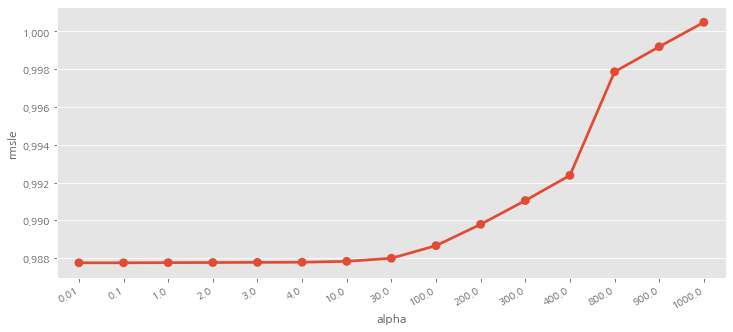

In [19]:
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

# 라쏘 Regularization Model - Lasso

- 선형회귀의 Regularization(규제)를 적용하는 대안
- 계수를 0에 가깝게 만들려고 하며 이를 L1규제라고 하며, 어떤 계수는 0이 되기도 하는데 이는 완전히 제외하는 피처가 생긴다는 의미다.
- 피처 선택이 자동으로 이루어진다고도 볼 수 있다.
- alpha 값의 기본 값은 1.0이며, 과소 적합을 줄이기 위해서는 이 값을 줄여야 한다.
- 그리드 서치로 아래 라쏘모델을 실행했을 때 베스트 알파값은 0.0025
- max_iter(반복 실행하는 최대 횟수)는 3000을 넣어주었다.

**Lasso가 ridge보다 성능이 좋은 이유는 중요한 몇개의 변수만 선택하고 다른 계수들은 0으로 줄입니다. 이 특징을 feature selection으로 알려져 있고, ridge regression은 이러한 과정이 없다.**

In [20]:
lasso_m_ = Lasso()

alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params_ = { 'max_iter':[3000],'alpha':alpha}

grid_lasso_m = GridSearchCV( lasso_m_,lasso_params_,scoring = rmsle_scorer,cv=5)
y_train_log = np.log1p(y_train)
grid_lasso_m.fit( X_train , y_train_log )
preds = grid_lasso_m.predict(X_train)
print (grid_lasso_m.best_params_)
print ("RMSLE Value For Lasso Regression: ",rmsle(np.exp(y_train_log),np.exp(preds),False))

df = pd.DataFrame(grid_lasso_m.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)

df[["alpha", "rmsle"]].head()

{'alpha': 0.00125, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  0.9803727821457647


,alpha,rmsle
0,10.000000,1.397124
1,1.000000,1.071947
2,0.500000,1.062110
3,0.333333,1.060815
4,0.250000,1.061139


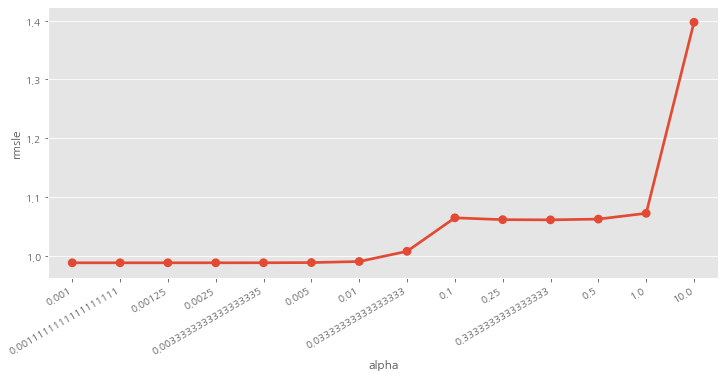

In [21]:
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

그렇다면 다음과 같은 상황을 생각해보자.

    10,000개의 변수가 있는 데이터셋이 있다. 그리고 이 변수들 중에는 서로 correlate(연관되어 있는) 변수들이 존재한다.

그렇다면 Ridge와 Lasso 중 어떤 예측 모형을 사용하는 것이 좋을까?

    1) Ridge를 사용한다면, 우리는 **모든 Feature를 이용하며 계수값을 줄일 것이다.** 즉, 아직 모델은 복잡한 상태이다. 다시 말해, 10,000개의 변수를 아직 유지하고 있는 것이다. 그로 인하여 성능이 저하될 수 있다.

    2) Lasso를 적용한다면 다음과 같은 문제가 발생할 수 있다. **변수들끼리 correlate하다면, Lasso는 하나의 변수만 채택하고 다른 correlate되어 있는변수들의 계수들은 0으로 바꿀 것이다.** 그로 인하여, 정보가 손실되어 정확성이 떨어질 수 있다.

이러한 문제들을 해결하기 위해 제안된 모델이 **Elastic Net Regression** 이다. 이 모델은 Ridge와 Lasso보다 높은 성능을 보일것으로 기대되지만, **다음과 같은 상황에서는 오히려 성능이 떨어진다.**

    변수의 갯수가 많지 않은 경우, Elastic Net의 성능을 기대하기 어렵다.
    
Elastic Net은 상관된 독립변수들을 하나의 그룹으로 묶어 regression을 진행한다. 해당 그룹에 강력한 예측 변수가 있다면, 해당 그룹 전체를 model buliding에 포함시킨다. 이 과정을 Lasso와 비교해보자. Lasso는 강력한 예측 변수 1개를 제외하고 나머지 변수들은 제거를 할 수 있는데 이 때 정보 솔실이 발생하여 모델의 성능이 저하된다. Elastic Net은 그룹 전체를 model building에 포함시키므로서 정보손실을 방지하고자 한다.

# 앙상블모델 - 랜덤포레스트

## Ensemble Models - Random Forest